# **Tarea Nº 4**
Scope: APIs

**Calificación: 19.5**

Curso:          Fundamentos de Programación en Python para Macroeconomía y Finanzas     
Profesor:       Victor Fuentes Campos     

- Fecha y hora de entrega: Viernes 12 de enero, 11:59pm
- Agregue los nombres de las personas con las que discutió esta tarea: ____ Elías Gómez y Gustavo Torres ______
- Envíe su tarea haciendo el `push` de su código a su repo en GitHub Classroom: 

The Central Bank Reserve of Perú (BCRP) holds a list of datasets that are among the most comprehensive for macroeconomic purposes. In this exercise, we'll retrieve data from the [BCRP API](https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api) and explore the impact of pandemics

## Before starting

- You must pull the necessary data using `get` and `requests`
- You are required to apply the concepts learned in the previous sessions (`pandas`, `if`, `loop`, `function`)
- Hint: here is the BCRP url structure for the APIs call:
```html
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[códigos de series]/[formato de salida]/[periodo inicial]/[periodo final]/[idioma]
```

## The very long run

1. Locate the "Estadísticas de 100 años del BCRP" section in the BCRP´s series data statistics [here](https://estadisticas.bcrp.gob.pe/estadisticas/series/index) and identify the necessary code for the serie **`PBI (Mill S/ 2007)`**. Later, add manually the annual GDP values for 2022 and 2023 (be careful with the units of data). Then, **calculate** the Peruvian annual GDP growth (%) since 1922 to 2023. Finally, plot it using a very simple graph through `matplotlib` and provide critical insights (no more than 100 words)

    Hint1: use `.json()` for exploring the `content`. Your data is inside `["periods"]`
    
    Hint2: the graph must looks something like this: <img src="growth_gdp_long_run.png" max-width="300">
    

In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from matplotlib.dates import YearLocator
import yfinance as yf
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import date, timedelta

In [2]:
# Solution
url_base  = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/'
cod_var   = 'PD39563DA' # PM05000AA
form_out  = '/json'
period    = '/1922/2021'
url_final = url_base+cod_var+form_out+period

PBI_BCRP=requests.get(url_final)
data = PBI_BCRP.json()

# Manually add GDP values for 2022 and 2023
data['periods'].append({'name': '2022', 'values': ['567390.123467761']})
data['periods'].append({'name': '2023', 'values': ['584723']})

In [3]:
periods = data['periods']
value   = []
for i in periods:
    aux = i['values']
    for j in aux:
        j = float(j)
        value.append(j)

dates = []
for i in periods:
    aux = i['name']
    dates.append(aux)
    
dict1 = {"Fecha":dates, "PBI (Mill S/ 2007)":value}

df0 = pd.DataFrame(dict1)
df0['Fecha'] = pd.to_datetime(df0['Fecha'])

# Set the "Fecha" column as the index
df0.set_index('Fecha', inplace=True)
df0.head()

,PBI (Mill S/ 2007)
Fecha,
1922-01-01,14122.032222
1923-01-01,14756.217373
1924-01-01,16069.798806
1925-01-01,16575.199473
1926-01-01,18130.193094


In [4]:
df0 = 100 * (np.log(df0) - np.log(df0.shift(1)))
df0.dropna(inplace=True)
df0.head()

,PBI (Mill S/ 2007)
Fecha,
1923-01-01,4.392836
1924-01-01,8.527715
1925-01-01,3.096591
1926-01-01,8.967110
1927-01-01,3.022696


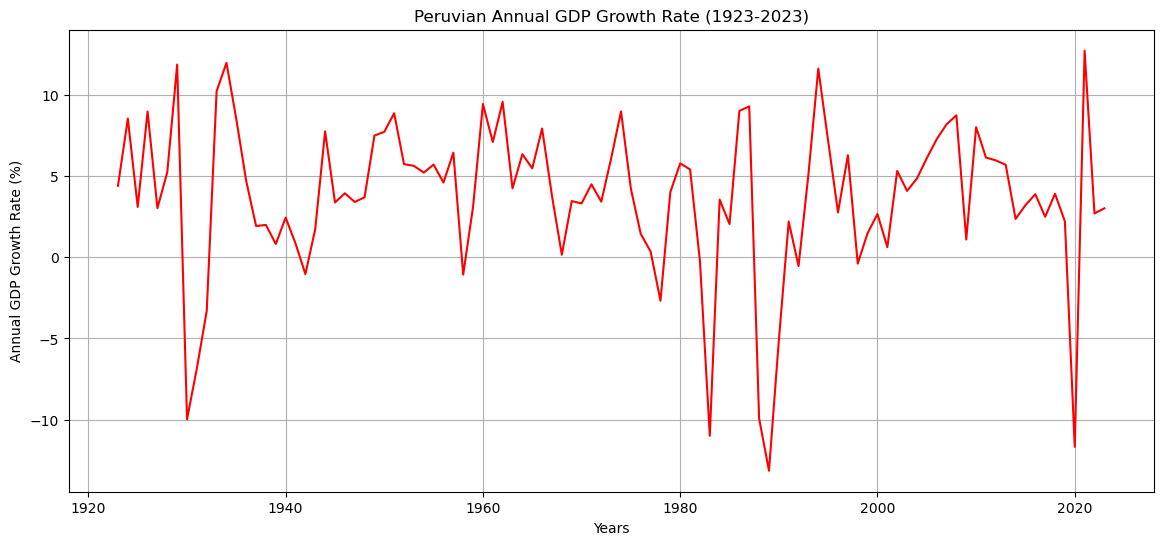

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df0.index, df0["PBI (Mill S/ 2007)"], linestyle='-', color='r')
ax.set_xlabel("Years")
ax.set_ylabel("Annual GDP Growth Rate (%)")
ax.set_title("Peruvian Annual GDP Growth Rate (1923-2023)")
plt.grid(True)
plt.show()

En el gráfico podemos apreciar los periodos de expansión y contracción de la economía peruana, entre los años 1923-2023. POr ejemplo se puede apreciar los picos contractivos en los años 1980 y 2021 debido a la hiperinflación del primer gobierno de Alan García y el comienzo de la cuarentena en el país, respectivamente. El análisis de estas tendencias puede ayudar a comprender mejor la resistencia y vulnerabilidad económicas del país, así como la eficacia de las distintas estrategias económicas a lo largo del siglo pasado.  

## The hitman

2. Retrieve the up-to-date data for the monthly GDP in index (2007=100) from this [link](https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/producto-bruto-interno-y-demanda-interna-variaciones-indice-2007). Then, calculate the the 5-year average monthly growth previous to the pandemics (ending in Feb-2020) for the 12-month rolling mean of the index, and project the alternative scenario of the Peruvian economy without the COVID-19. Then plot them out and provide insight from the gap between the real data and the pre-pandemic trend.

    Hint1: You may use the regression type of your election, but the OLS is recommended. 
    
    Hint2: Your plot should look somethig like this. You aren´t required to add flags/annotations/texts inside the graph <img src="growth_gdp_pandemics.png" max-width="300">

    Hint3: For more details about calculation, review this post from [The Economist](https://www.economist.com/graphic-detail/2021/10/28/americas-post-covid-economic-recovery-suffers-a-setback)
    


In [6]:
url_base  = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/'
cod_var   = 'PN01770AM'
form_out  = '/json'
period    = '/2003-01/2023-10'

month_s = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']
month_d = ['01','02','03','04','05','06','07','08','09','10','11','12']
df1 = pd.DataFrame()

url_aux   = url_base + cod_var + form_out + period
resp      = requests.get(url_aux)
resp_json = resp.json()
periods   = resp_json['periods']

value = []
dates = []

for i in periods:
    aux_dat = i['name']
    aux_val = i['values']
    dates.append(aux_dat)
    value.append(float(aux_val[0]))

dict_aux = {'Fecha' : dates,
             resp_json['config']['series'][0]['name'] : value}
df_aux = pd.DataFrame(dict_aux)

df_aux['Fecha'] = df_aux['Fecha'].str.replace('.','-')
for (s,d) in zip(month_s,month_d):
    df_aux['Fecha'] = df_aux['Fecha'].str.replace(s,d)
df_aux['Fecha'] = pd.to_datetime(df_aux['Fecha'])

df_aux.set_index(df_aux['Fecha'], inplace=True)
df_aux = df_aux.drop(columns=['Fecha'])
df1    = pd.concat([df1, df_aux], axis=1)

C:\Users\Aixa\AppData\Local\Temp\ipykernel_18968\1257700061.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_aux['Fecha'] = df_aux['Fecha'].str.replace('.','-')


In [7]:
df1 = df1.rolling(window=12).mean()
df1 = df1 / df1.loc["2020-02-01"]
df1.dropna(inplace=True)

In [8]:
pre_pandemic_data = df1.loc[(df1.index >= '2015-02-01') & (df1.index <= '2020-02-29')]

# Calcular el crecimiento mensual
pre_pandemic_data['Crecimiento_Mensual'] = pre_pandemic_data[pre_pandemic_data.columns[0]].pct_change()

# Calcular el crecimiento mensual promedio
crecimiento_promedio = pre_pandemic_data['Crecimiento_Mensual'].mean()

print(f'Crecimiento mensual promedio de los 5 años anteriores a la pandemia: {crecimiento_promedio:.2%}')

pre_pandemic_data.dropna(inplace=True)
pre_pandemic_data.head()

Crecimiento mensual promedio de los 5 años anteriores a la pandemia: 0.27%


C:\Users\Aixa\AppData\Local\Temp\ipykernel_18968\3665822105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_pandemic_data['Crecimiento_Mensual'] = pre_pandemic_data[pre_pandemic_data.columns[0]].pct_change()
C:\Users\Aixa\AppData\Local\Temp\ipykernel_18968\3665822105.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_pandemic_data.dropna(inplace=True)


,Producto bruto interno y demanda interna (índice 2007=100) - PBI,Crecimiento_Mensual
Fecha,,
2015-03-01,0.853645,0.002405
2015-04-01,0.856607,0.003469
2015-05-01,0.857526,0.001073
2015-06-01,0.860389,0.003339
2015-07-01,0.862971,0.003001


In [9]:
months_to_project = 45
for i in range(1, months_to_project + 1):
    last_date = pre_pandemic_data.index.max()
    next_date = last_date + pd.DateOffset(months=1)
    pre_pandemic_data.loc[next_date, 'Producto bruto interno y demanda interna (índice 2007=100) - PBI'] = pre_pandemic_data['Producto bruto interno y demanda interna (índice 2007=100) - PBI'].iloc[-1] * (1 + crecimiento_promedio)

C:\Users\Aixa\AppData\Local\Temp\ipykernel_18968\2214538081.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_pandemic_data.loc[next_date, 'Producto bruto interno y demanda interna (índice 2007=100) - PBI'] = pre_pandemic_data['Producto bruto interno y demanda interna (índice 2007=100) - PBI'].iloc[-1] * (1 + crecimiento_promedio)


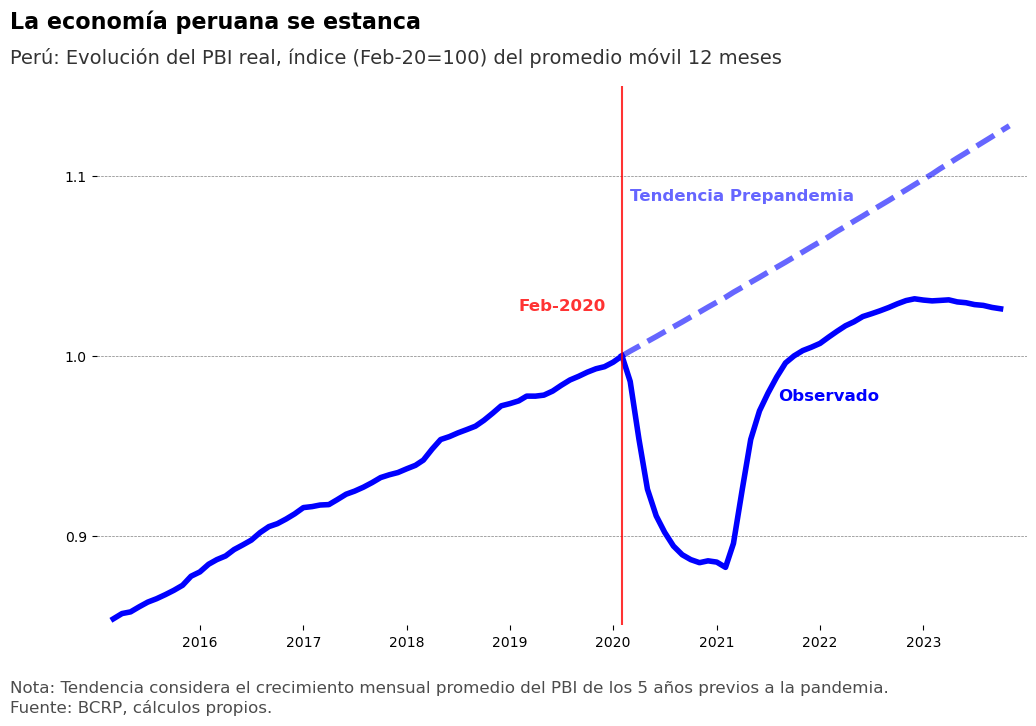

In [10]:
post_pandemic_data = df1.loc[(df1.index >= '2020-02-01') & (df1.index <= '2023-10-31')]

grosor_linea = 4.0
fig, ax = plt.subplots(figsize=(12, 7))

# Gráficos
ax.plot(pre_pandemic_data.index[:60], pre_pandemic_data[pre_pandemic_data.columns[0]][:60], linestyle='-', color='b', linewidth=grosor_linea)
ax.plot(post_pandemic_data.index, post_pandemic_data[post_pandemic_data.columns[0]], linestyle='-', color='b', linewidth=grosor_linea)
ax.plot(pre_pandemic_data.index[59:], pre_pandemic_data[pre_pandemic_data.columns[0]][59:], linestyle='--', color='b', linewidth=grosor_linea, alpha=0.6)

# Subtítulo sin negrita

fecha_vertical = pd.Timestamp('2020-02-01')
ax.axvline(x=fecha_vertical, color='red', linestyle='-', label='Línea Vertical', alpha=0.8)
ax.annotate("Observado", xy=(pd.Timestamp('2021-10-06'), 1), xytext=(pd.Timestamp('2021-08-06'), 0.975), color='b', fontsize=12, weight='bold')
ax.annotate("Tendencia Prepandemia", xy=(pd.Timestamp('2020-03-01'), 1), xytext=(pd.Timestamp('2020-03-01'), 1.08625), color='b', alpha=0.6, fontsize=12, weight='bold')
ax.annotate("Feb-2020", xy=(pd.Timestamp('2019-03-01'), 1), xytext=(pd.Timestamp('2019-02-01'), 1.025), color='r', alpha=0.8, fontsize=12, weight='bold')
ax.annotate("La economía peruana se estanca", xy=(pd.Timestamp('2015-03-01'), 1), xytext=(pd.Timestamp('2014-03-01'), 1.1825), color='black', alpha=1, fontsize=16, weight='bold')
ax.annotate("Perú: Evolución del PBI real, índice (Feb-20=100) del promedio móvil 12 meses", xy=(pd.Timestamp('2015-03-01'), 1), xytext=(pd.Timestamp('2014-03-01'), 1.1625), color='black', alpha=0.8, fontsize=14)
ax.annotate("Nota: Tendencia considera el crecimiento mensual promedio del PBI de los 5 años previos a la pandemia.", xy=(pd.Timestamp('2015-03-01'), 1), xytext=(pd.Timestamp('2014-03-01'), 0.8125), color='black', alpha=0.7, fontsize=12)
ax.annotate("Fuente: BCRP, cálculos propios.", xy=(pd.Timestamp('2015-03-01'), 1), xytext=(pd.Timestamp('2014-03-01'), 0.80125), color='black', alpha=0.7, fontsize=12)
# Ocultar el cuadro alrededor del gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Configuración de ejes y marcas en el eje Y
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Establecer límites y marcas en el eje Y
ax.set_ylim(0.85, 1.15)
ax.set_yticks([0.9, 1, 1.1])

ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2024-01-01'))
ax.set_xticks([pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'), 
               pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'),
               pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'),
               pd.Timestamp('2022-01-01'),pd.Timestamp('2023-01-01')])
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.grid(True, axis='y', linestyle='--', color='gray', linewidth=0.5)
plt.show()


Gran código! No hay conclusiones :(

**Calificación: -0.5**

## The winners

- Based on the [Nasdaq Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener), identify the three largest companies in the three larger sectors defined by market cap
- Elaborate a list/dictionary/series (what ever you think is more suitable) containing all tickers (or symbols) and sectors from these companies.
- So far, you can download data from Nasdaq, web scrape it or copy it manually. It doesn´t matter
- Then, use `yfinance` library to retrieve the market data for all the 9 firms
- Construct a table with the most common *institucional holders* by sector. Is there any interesting pattern? Hint: loop the `institutional_holders` from `yfinance`
- Calculate the distribution of the daily percentage returns for the 3 larger companies (defined by market cap) along the last 5 years. Plot your results (feel free to find the most appealing way to represent them) and provide critical insights

$$
  percentage\_return_{t} = \frac{price_t-price_{t-1}}{price_t}*100+dividends (\%)
$$

- Hint1: you can find the `dividens` through the `yfinance`'s 
`Ticker()`
- Hint2: some firms may not be paying dividends

In [11]:
# Solution
dataframe_csv = pd.read_csv('nasdaq_screener_17.csv')
dataframe_seleccionado = dataframe_csv[['Symbol', 'Name', 'Market Cap', 'Sector']]

# Identificar los tres sectores más grandes
top_sectores = dataframe_seleccionado.groupby('Sector')['Market Cap'].sum().nlargest(3).index.tolist()

# Crear un DataFrame vacío para almacenar los resultados
resultados = pd.DataFrame(columns=['Sector', 'Symbol', 'Name', 'Market Cap'])

# Iterar sobre los tres sectores más grandes
for sector in top_sectores:
    # Seleccionar las empresas del sector actual
    empresas_sector = dataframe_seleccionado[dataframe_seleccionado['Sector'] == sector]
    
    # Identificar las tres empresas más grandes en el sector
    top_empresas_sector = empresas_sector.nlargest(3, 'Market Cap')[['Symbol', 'Name', 'Market Cap']]
    
    # Agregar los resultados al DataFrame final
    top_empresas_sector['Sector'] = sector
    resultados = pd.concat([resultados, top_empresas_sector])

# Mostrar los resultados en formato de tabla
print(resultados.to_markdown(index=False))

| Sector                 | Symbol   | Name                                     |   Market Cap |
|:-----------------------|:---------|:-----------------------------------------|-------------:|
| Technology             | AAPL     | Apple Inc. Common Stock                  |  2.89157e+12 |
| Technology             | MSFT     | Microsoft Corporation Common Stock       |  2.88721e+12 |
| Technology             | GOOG     | Alphabet Inc. Class C Capital Stock      |  1.80531e+12 |
| Consumer Discretionary | AMZN     | Amazon.com Inc. Common Stock             |  1.59785e+12 |
| Consumer Discretionary | TSLA     | Tesla Inc. Common Stock                  |  6.95834e+11 |
| Consumer Discretionary | V        | Visa Inc.                                |  4.84923e+11 |
| Finance                | HSBC     | HSBC Holdings plc. Common Stock          |  7.7551e+11  |
| Finance                | JPM      | JP Morgan Chase & Co. Common Stock       |  4.88725e+11 |
| Finance                | BAC      | Ba

In [12]:
tickers = list(resultados["Symbol"])
name = list(resultados["Name"])
sector = list(resultados["Sector"])
data_dic = {"Tickers": tickers, "Sector": sector}

In [13]:
date_1 = date.today()
date_2 = date_1 - timedelta(days=30*60)
# Textual month, day and year
t_start = date_2.strftime("%Y-%m-%d")
t_end = date_1.strftime("%Y-%m-%d")

empresas = tickers
nombres_archivos = name

lst_df = []

for codigo, empresa  in zip(empresas, nombres_archivos):
  data = yf.download(codigo, start=t_start, end=t_end)
  data["Company"] = codigo
  data.reset_index(inplace=True)
  lst_df.append(data)
    
df = pd.concat(lst_df, axis=0, ignore_index=True)
print(df.shape)
df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(11169, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,2019-02-08,42.247501,42.665001,42.105000,42.602501,41.065708,95280000,AAPL
1,2019-02-11,42.762501,42.802502,42.312500,42.357498,40.829552,83973600,AAPL
2,2019-02-12,42.525002,42.750000,42.424999,42.722500,41.181381,89134000,AAPL
3,2019-02-13,42.847500,43.119999,42.480000,42.544998,41.010281,89960800,AAPL
4,2019-02-14,42.427502,42.814999,42.345001,42.700001,41.159706,87342800,AAPL


In [14]:
holders_df_list = [
    yf.Ticker(ticker).institutional_holders.assign(Symbol=ticker, Sector=sector)
    for ticker, sector in zip(data_dic["Tickers"], data_dic["Sector"])
]

holders_df = pd.concat(holders_df_list, ignore_index=True)
print(holders_df.groupby(['Symbol'])[["pctHeld", "Shares", "Value", "Holder"]].max().to_markdown(index=True))

| Symbol   |   pctHeld |     Shares |        Value | Holder                           |
|:---------|----------:|-----------:|-------------:|:---------------------------------|
| AAPL     |    0.0834 | 1303688506 | 252876459508 | Vanguard Group Inc               |
| AMZN     |    0.0704 |  725913766 |  94630118535 | Vanguard Group Inc               |
| BAC      |    0.13   | 1032852006 |  29632524052 | Vanguard Group Inc               |
| GOOG     |    0.0722 |  413428897 |  50012493670 | Vanguard Group Inc               |
| HSBC     |    0.0028 |   10964950 |    434431319 | Renaissance Technologies, LLC    |
| JPM      |    0.0941 |  273451539 |  39770791832 | Wellington Management Group, LLP |
| MSFT     |    0.0879 |  653247546 | 222456919314 | Vanguard Group Inc               |
| TSLA     |    0.0701 |  222486933 |  58240404451 | Vanguard Group Inc               |
| V        |    0.0881 |  141523414 |  33608980356 | Vanguard Group Inc               |


Al analizar los datos, se destaca la presencia preeminente del "Vanguard Group Inc" como el principal tenedor. Este hallazgo sugiere que Vanguard Group Inc podría ser la principal entidad gestora de fondos de inversión a nivel mundial. La estrategia de inversión implementada por Vanguard Group Inc adquiere un carácter notablemente influyente, ya que ostentan la participación más significativa en acciones de las empresas más valoradas a nivel global.

Dada la envergadura de este grupo, sus modelos de valoración podrían influir de manera sustancial en la dinámica de los precios de las acciones, llevándolos a dejar de ser exógenos. Este caso resulta particularmente interesante y revelador en el contexto financiero.

In [15]:
# Identifica las tres empresas más grandes del DataFrame filtrado
top_empresas_filtradas = dataframe_seleccionado.nlargest(3, 'Market Cap')

# Lista de símbolos de las tres mejores empresas
tickers_tres_mejores = top_empresas_filtradas['Symbol'].tolist()

# Crear un diccionario para almacenar los datos de precios y dividendos
data_dict = {}

# Iterar sobre los símbolos de las empresas
for ticker in tickers_tres_mejores:
    # Obtener datos históricos de precios y dividendos
    data = yf.Ticker(ticker).history(period='5y')
    data_dict[ticker] = data

# Calcular los rendimientos porcentuales diarios
for ticker, data in data_dict.items():
    data['Daily_Return'] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1) * 100
    # Agregar dividendos si están disponibles
    if 'Dividends' in data.columns:
        data['Daily_Return'] += data['Dividends'] / data['Close'] * 100

# Crear un DataFrame combinado con los rendimientos porcentuales diarios
combined_df = pd.concat([data_dict[ticker]['Daily_Return'].rename(ticker) for ticker in tickers_tres_mejores], axis=1)
combined_df.dropna(inplace=True)
combined_df.head()

,AAPL,MSFT,GOOG
Date,,,
2019-01-15 00:00:00-05:00,2.046660,2.900530,3.107137
2019-01-16 00:00:00-05:00,1.221663,0.352338,0.354643
2019-01-17 00:00:00-05:00,0.593758,0.702239,0.826108
2019-01-18 00:00:00-05:00,0.615947,1.498294,0.767042
2019-01-22 00:00:00-05:00,-2.244595,-1.884674,-2.525809


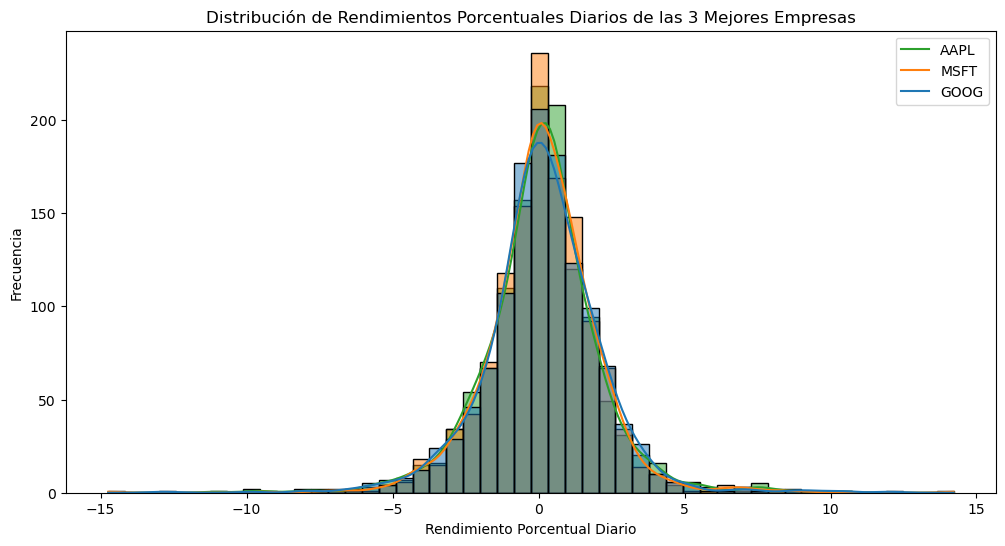

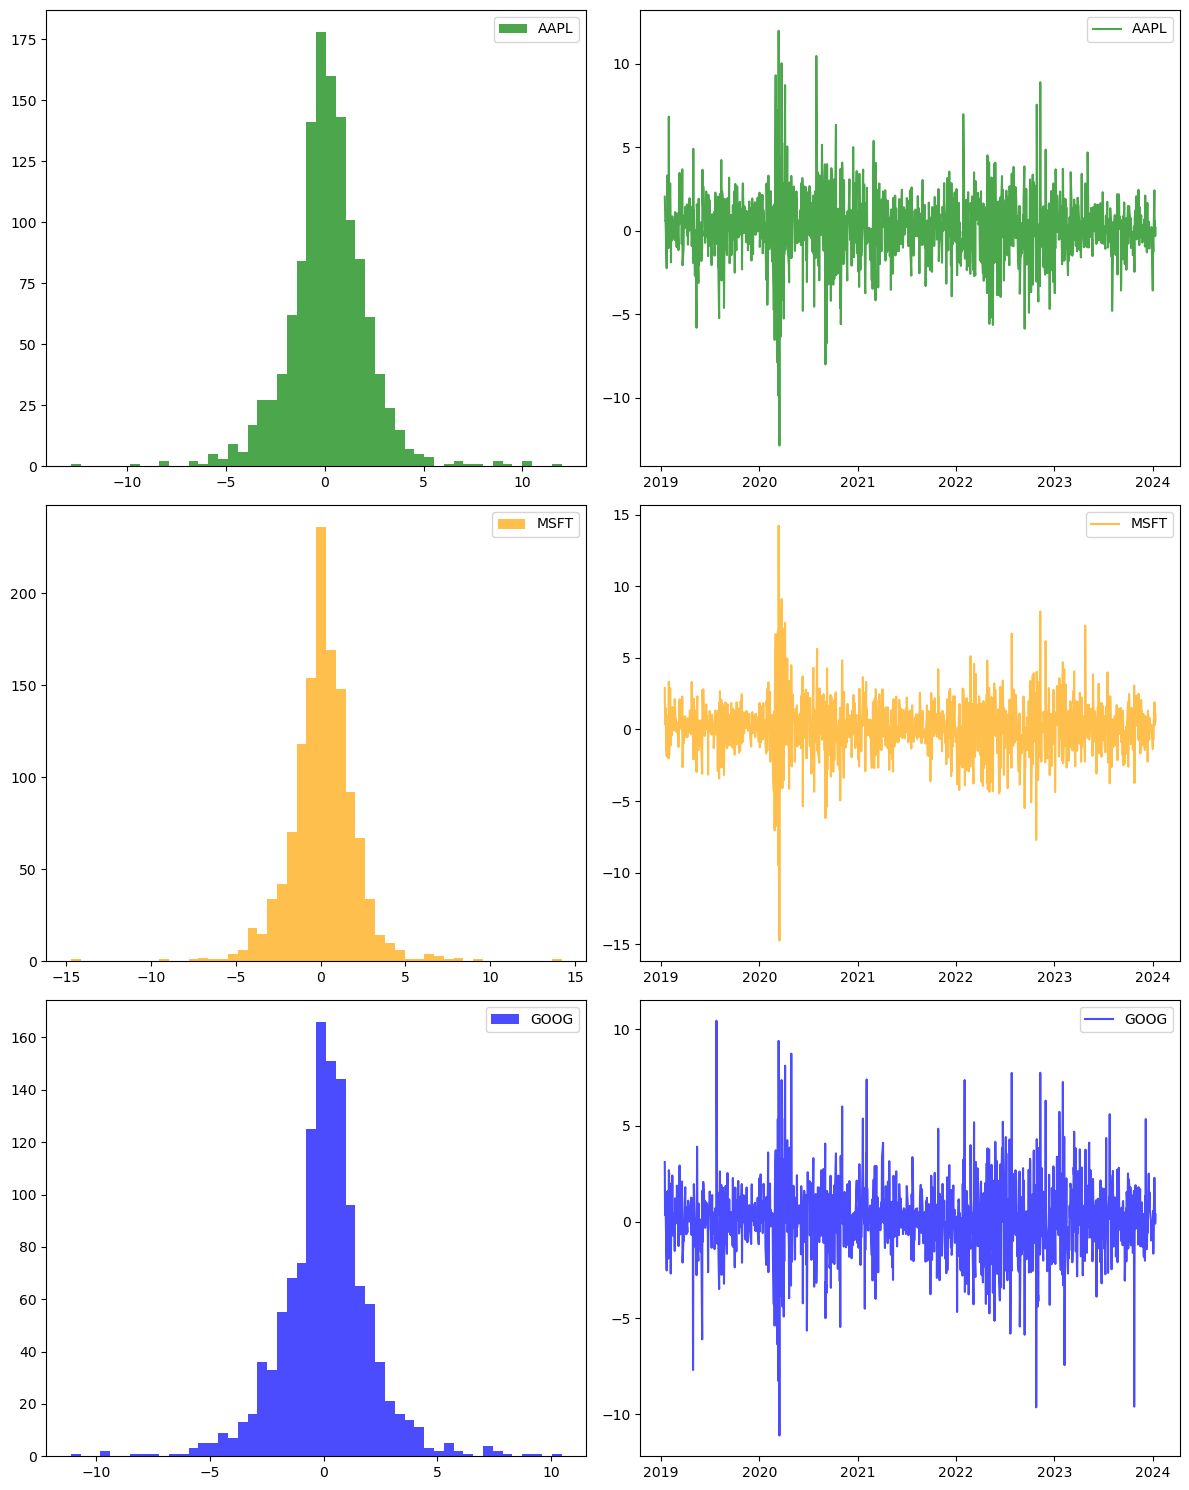

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, bins=50, kde=True)
plt.title('Distribución de Rendimientos Porcentuales Diarios de las 3 Mejores Empresas')
plt.xlabel('Rendimiento Porcentual Diario')
plt.ylabel('Frecuencia')
plt.legend(tickers_tres_mejores)
plt.show()

# Crear subplots con histogramas en la columna y un gráfico simple en la fila
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
colores = ['green', 'orange', 'blue']

for i, ticker in enumerate(tickers_tres_mejores):
    axs[i, 0].hist(combined_df[ticker], bins=50, color=colores[i], alpha=0.7, label=ticker)
    axs[i, 1].plot(combined_df[ticker], color=colores[i], alpha=0.7, label=ticker)
    axs[i, 0].legend()
    axs[i, 1].legend()

plt.tight_layout()
plt.show()

Podemos notar que al inicio de 2020 existe una notable volatilidad en los rendimientos de acciones para las tres compañías. Este fenómeno parece ser consecuencia de la incertidumbre generada por la pandemia de Covid-19. Es importante recordar que durante períodos de crisis, los inversionistas institucionales tienden a refugiarse en instrumentos considerados más seguros, como commodities y letras del tesoro. En otras palabras, adoptan posiciones de venta con respecto a acciones y posiciones de compra en bonos u otros activos percibidos como seguros.

Adicionalmente, se destaca la imprevisibilidad de los retornos de acciones per se, dado que la media está centrada en cero y la volatilidad parece no mantenerse constante a lo largo del tiempo. Si tuviéramos una varianza constante y un histograma sin colas largas ni anchas, podríamos estar en presencia de un fenómeno conocido como Ruido Blanco, característico de los rendimientos en el mercado bursátil.

En el caso específico de Google, se observa un aumento en la volatilidad de sus rendimientos hacia finales de 2022. Este incremento podría estar relacionado con la introducción de un producto disruptivo en la industria. Cabe mencionar que a finales de noviembre del 2022, Open AI lanzó ChatGPT, lo que podría haber influido en la percepción del mercado y, consecuentemente, en la variabilidad de los rendimientos de acciones de Google.

Genial!